# Tutorial 02: Model-Based Spectral Calibration using SVMBIR
This tutorial introduces a **model-based spectral calibration** approach using the [SVMBIR](https://github.com/cabouman/svmbir)
 projector. 

In this tutorial, we will 
- simulate multi-energy dataset using SVMBIR projector
  - simulate CT scans with specific source, filter, and detector configurations. 
  - scan multiple materials at different source voltages to generate multi-energy dataset. 
- model-based spectral calibration
  - Step 0: Obtain sample masks and calculate forward matrix.
  - Step 1: Configure Spectral Models including source, filters, and detector(scintillator).
  - Step 2: Spectral Calibration.

## X-ray System Setup

### Source
- **Type**: Reflection
- **Take-off Angle**: 13°
- **Voltages Used for Scanning**:
  - 50 kV
  - 100 kV
  - 150 kV

### Filter
- **Material**: Aluminum (Al)
- **Thickness**: 3 mm

### Detector
- **Material**: Cesium Iodide (CsI)
- **Thickness**: 0.33 mm

### Samples
- **Shapes**: Rods with 0.5 mm radius
- **Materials**: 
  - Vanadium (V)
  - Aluminum (Al)
  - Titanium (Ti)
  - Magnesium (Mg)
- **Height**: 0.2 mm

### CT Geometry
- **Beam Type**: Parallel Beam
- **Detector Specifications**:
  - **Pixel Size**: 0.01 mm × 0.01 mm
  - **Scan Shape**: 50 × 512 pixels
- **Number of Views**: 64

In [1]:
import numpy as np
import matplotlib.pyplot as plt

max_simkV = 180 # keV
takeoff_angle = 13 # degree
voltage_list = [40, 80, 180] # keV
mas_list = [0.01,0.01,0.01] # Milliampere-seconds

fltr_mat = 'Al' # filter material
fltr_th = 3 # filter thickness in mm

det_mat = 'CsI' # scintillator material
det_density = 4.51 # scintillator density g/cm^3
det_th = 0.33 # scintillator thickness in mm

sample_mats = ['V', 'Al', 'Ti', 'Mg']
sample_radius = 0.5 # sample diameter in mm


ct_info = {
    "Geometry": "Parallel",
    "psize": [0.01, 0.01],  # Width and height in mm
    "rsize": [0.01, 0.01],
    "shape": [50, 512],     # Rows and columns
    "NViews": 64
}

## A. Simulate multi-energy dataset using SVMBIR projector

### A01. Ground Truth Source Spectra
In this tutorial,
- use spekpy to generate X-ray source spectum.
- the description of 2 used functions from spekpy is shown below by the help function.

In [2]:
import spekpy as sp
help(sp.Spek.__init__)

Help on function __init__ in module spekpy.SpekPy:

__init__(self, kvp=None, th=None, dk=None, mu_data_source=None, physics=None, x=None, y=None, z=None, mas=None, brem=None, char=None, obli=None, comment=None, targ=None, shift=None, init_default=True)
    Constructor method for the Spek class 
    
    SEE THE WIKI PAGES FOR MORE INFO:
    https://bitbucket.org/spekpy/spekpy_release/wiki/Further_information
    
    :param float kvp: tube potential [kV] (default: depends on target)
    :param float th: anode angle [degrees] (default: 12 degrees)
    :param float dk: energy bin width [keV] (default: 0.5 keV)
    :param string: mu_data_source (default: depends on physics model)
        options: ('pene' or 'nist')
    :param float physics: physics model (default: 'casim')
        options: ('casim', 'kqp', 'spekpy-v1', 'spekcalc',
                  'diff', 'uni', 'sim', 'classical')
    :param float x: displacement from central axis in anode-cathode 
        direction [cm] (default: 0 cm)

In [3]:
help(sp.Spek.get_spectrum)

Help on function get_spectrum in module spekpy.SpekPy:

get_spectrum(self, edges=False, flu=True, diff=True, sig=None, addend=False, **kwargs)
    A method to get the energy and spectrum for the parameters in the 
    current spekpy state
    
    :param bool edges: Keyword argument to determine whether midbin or edge
        of bins data are returned
    :param bool addend: Keyword argument to determine whether a zero
        end point is added to the spectrum
    :param bool flu: Whether to return fluence or energy-fluence
    :param bool diff: Whether to return spectrum differential in energy
    :param kwargs: Keyword arguments to change parameters that are used for
        the calculation
    :return array k: Array with photon energies (mid-bin or edge values)
        [keV]
    :return array spk: Array with corresponding photon fluences 
        [Photons cm^-2 keV^-1], [Photons cm^-2] or [Photons cm^-2 keV^1]
        depending of values of flu and diff inputs


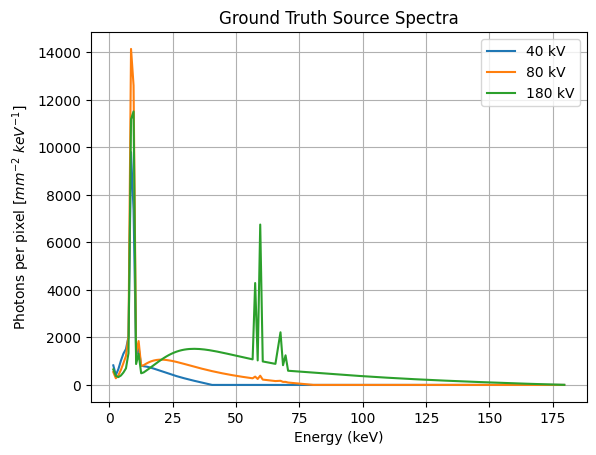

In [4]:
max_simkV = max(voltage_list)
takeoff_angle = 13

# Define energy bins from 1.5 keV up to (max_simkV - 0.5) keV.
energies = np.linspace(1.5, max_simkV - 0.5, max_simkV-1)

# Initialize an empty list to store the generated source spectra.
gt_src_spec_list = []

for case_i, simkV in enumerate(voltage_list):
    # Generate the X-ray spectrum model with Spekpy for each voltage.
    # kvp is source voltage
    # th is anode angle
    # dk is energy bin size
    # z is focus-to-detector distance [cm], use source-detector distance instead and convert mm to cm.
    # mas is current-time product mA*s
    # char=True requests characteristic x rays.
    s = sp.Spek(kvp=simkV, th=takeoff_angle, dk=1,z=1, mas=mas_list[case_i], char=True)
    
    # Return data at the mid of a bin or the edges of a bin.
    k, phi_k = s.get_spectrum(edges=False)  # Retrieve energy bins and fluence spectrum [Photons cm^-2 keV^-1]
    
    # Adjust the fluence for the detector pixel area.
    phi_k = phi_k * ((ct_info['psize'][0] / 10) * (ct_info['psize'][1] / 10))  # Convert pixel size from cm² to mm²

    # Initialize a zero-filled spectrum array with length max_simkV.
    src_spec = np.zeros(max_simkV-1)
    src_spec[:simkV-1] = phi_k  # Assign spectrum values starting from 1.5 keV

    # Add the processed spectrum for this voltage to the list.
    gt_src_spec_list.append(src_spec)

# Convert the list of source spectra to a numpy array for easy handling.
gt_src_spec_list = np.array(gt_src_spec_list)

# Plot each generated source spectrum.
for src_i, gt_src_spec in enumerate(gt_src_spec_list):
    plt.plot(energies, gt_src_spec, label='%d kV' % voltage_list[src_i])

plt.title('Ground Truth Source Spectra')
plt.xlabel('Energy (keV)')
plt.ylabel('Photons per pixel [$mm^{-2}$ $keV^{-1}$]')
plt.grid()
plt.legend()

#### A02. Ground Truth Filter Response
Filter response is defined as
$$
f(E) = e^{-\mu(m, E)\cdot t} 
$$
where $t$ is thickness; $\mu$ is linear attenuation coefficient(LAC), which depends on photon energy and material $m$ formula and density.

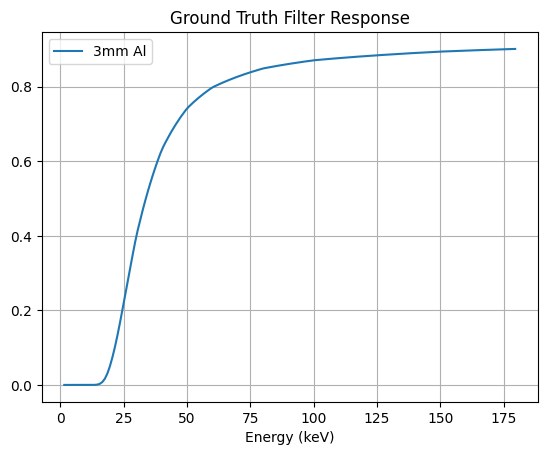

In [5]:
from xspec import get_filter_response
from xspec.chem_consts._periodictabledata import density

# get_filter_response returns a ratio of passing through photons.
# F(E) = e^(-\mu_{mat}(E)*thickness) 
# \mu_{mat}(E) = mac{mat}(E) * density
# where \mu denotes linear attenuation coefficient; mac means mass attenuation coefficient.
gt_fltr = get_filter_response(energies, fltr_mat, density[fltr_mat], fltr_th)

plt.plot(energies, gt_fltr, label='3mm Al')
plt.title('Ground Truth Filter Response')
plt.legend()
plt.xlabel('Energy (keV)')
plt.grid()

### A03. Ground Truth Detector Response

Converted energy from a X-ray photon with energy from 1 to 180 keV. 

Detector response is defined as
$$
D(E) =\frac{\mu_{en}(m, E)}{\mu(m, E)} (1 - e^{-\mu(m, E)\cdot t} )
$$
where $t$ is scintillator thickness; $\mu$ is linear attenuation coefficient(LAC), which depends on photon energy $E$ and material $m$ formula and density; $\mu_en$ is linear energy-absorption coefficient(LAC).

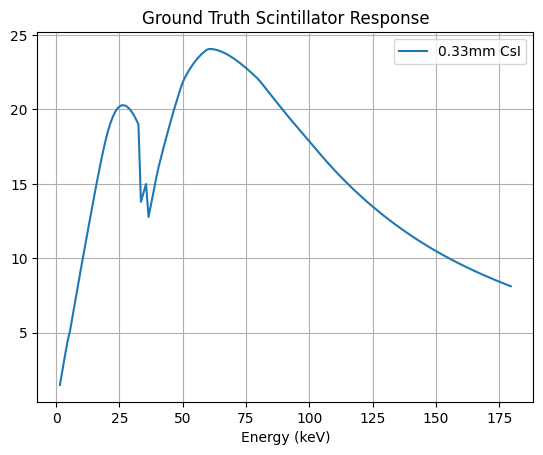

In [6]:
from xspec import get_scintillator_response
from xspec.chem_consts._periodictabledata import density

# get_scintillator_response returns converted energy per photon at energy E.
# D(E) = -\mu_en/\mu * (1-e^(-\mu(E)*thickness))
# \mu(E) = mac(E) * density
# \mu_en(E) = mac_en(E) * density
# where \mu denotes linear attenuation coefficient; mac means mass attenuation coefficient.
# where \mu_en denotes linear energy-absorption coefficient; mac_en means mass energy-absorption coefficient.
gt_det = get_scintillator_response(energies, det_mat, det_density, det_th)

plt.plot(energies, gt_det, label='%.2fmm %s'%(det_th, det_mat))
plt.title('Ground Truth Scintillator Response')
plt.legend()
plt.xlabel('Energy (keV)')
plt.grid()

### A04. Linear Attenuation Coefficients of homogenous samples

In [7]:
from xspec.chem_consts import get_lin_att_c_vs_E
help(get_lin_att_c_vs_E)

Help on function get_lin_att_c_vs_E in module xspec.chem_consts._consts_from_table:

get_lin_att_c_vs_E(density, formula, energy_vector)
    Calculate the linear attenuation coefficient (mu) as a function of energy,
    using mass attenuation coefficients from the NIST website:
    https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html.
    
    Author: Wenrui Li, Purdue University
    Date: 04/12/2022
    
    Parameters
    ----------
    density : float
        Density of the material in g/cm^3.
    formula : str/dict
        Chemical formula of the compound, either as a string or a dict.
        For example, "H2O" and {"H": 2, "O": 1} are both acceptable.
    energy_vector : list/numpy.ndarray
        Energy (units: keV) list or 1D array for which beta values are calculated.
    
    Returns
    -------
    numpy.ndarray
        Linear attenuation coefficient values in mm^-1, with the same size as energy_vector.


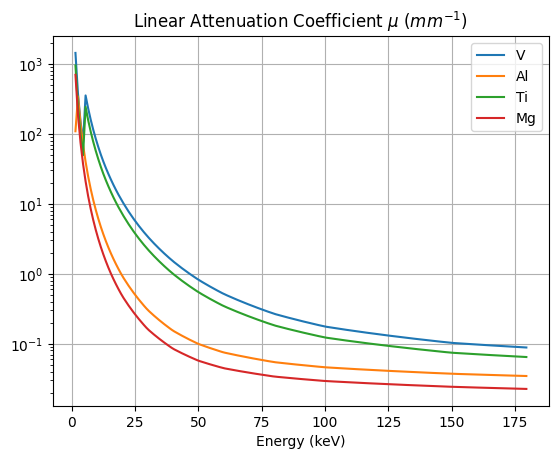

In [8]:
# Scanned Homogeneous Rods
# Density for homogenous material is stored in the imported density dictionary
mat_density = [density[formula] for formula in sample_mats]
lac_vs_E_list = [get_lin_att_c_vs_E(den, formula, energies) for den, formula in zip(mat_density, sample_mats)]

# Plot LAC
for lac_vs_E,mat in zip(lac_vs_E_list, sample_mats):
    plt.plot(energies, lac_vs_E, label=mat)
plt.yscale('log')
plt.title(r'Linear Attenuation Coefficient $\mu$ ($mm^{-1}$)')
plt.xlabel('Energy (keV)')
plt.grid()
plt.legend()

### A05. GT X-ray System Spectral Responses

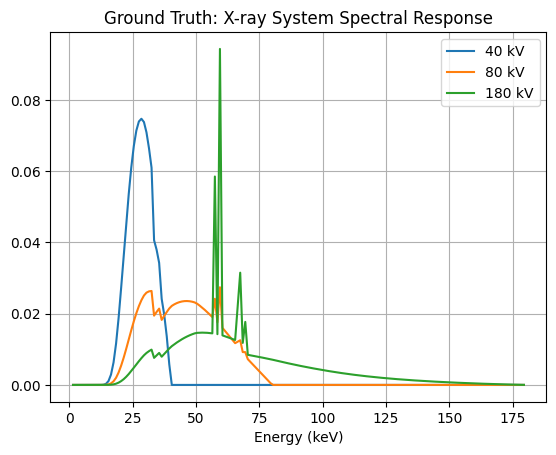

In [9]:
gt_spec_list = [gt_source * gt_fltr  * gt_det for gt_source in gt_src_spec_list]
for spec_i, gt_spec in enumerate(gt_spec_list):
    plt.plot(energies, gt_spec/np.trapz(gt_spec,energies), label='%d kV'%voltage_list[spec_i])
plt.legend()
plt.title('Ground Truth: X-ray System Spectral Response')
plt.xlabel('Energy (keV)')
plt.grid()
plt.legend()

### A06. Masks for 4 homogenous samples

Obtain a list of mask for each corresponding homogenous sample rod.
These masks is then used to calculate the forward matrix for the transmission function.

In [10]:
from xspec._utils import Gen_Circle
help(Gen_Circle.__init__)

Help on function __init__ in module xspec._utils:

__init__(self, canvas_shape, pixel_size)
    Initialize the Circle class.
    
    Parameters:
    canvas_shape (tuple): The shape of the canvas, in pixels.
    pixel_size (tuple): The size of a pixel, in the same units as the canvas.


In [11]:
help(Gen_Circle.generate_mask)

Help on function generate_mask in module xspec._utils:

generate_mask(self, radius, center=None)
    Generate a binary mask for the circle.
    
    Parameters:
    radius (int): The radius of the circle, in pixels.
    center (tuple): The center of the circle.
    
    Returns:
    ndarray: A 2D numpy array where points inside the circle are marked as True and points outside are marked as False.


Text(0.5, 1.0, 'Phantom: 4 homogenous samples')

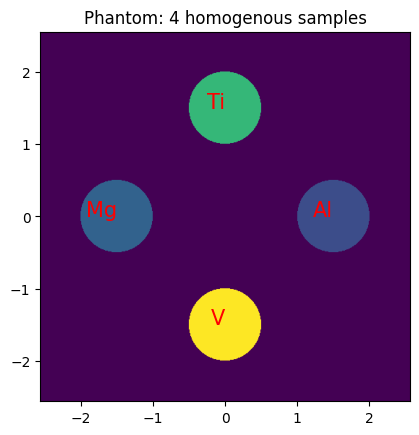

In [12]:
# Define parameters for 4 cylinders with 0.5mm radius, evenly distributed on a circle with a radius of 1.5mm.
Radius = [sample_radius for _ in range(len(sample_mats))]  # Radius of each cylindrical cross-section in mm
arrange_with_radius = 1.5  # Radius of the circle on which cylinder centers are distributed (in mm)

# Calculate center positions for each cylinder, evenly spaced around the circular arrangement
centers = [[np.sin(rad_angle) * arrange_with_radius, np.cos(rad_angle) * arrange_with_radius]
           for rad_angle in np.linspace(-np.pi / 2, -np.pi / 2 + np.pi * 2, len(sample_mats), endpoint=False)]

# Generate 3D masks for each cylinder
# Obtain a list of mask for each corresponding homogenous sample rod. 
# These masks is then used to calculate the forward matrix for the transmission function.
mask_list = []
for mat_id, mat in enumerate(sample_mats):
    # Initialize a circular mask generator for 2D slices
    # Use the number of column pixels to define a canvas
    circle = Gen_Circle((ct_info["shape"][1], ct_info["shape"][1]), 
                        (ct_info["rsize"][0], ct_info["rsize"][1])) # Image volume size
    # Create a 3D mask array for the current cylinder by repeating the circular 2D mask across slices
    mask_3d = np.array([circle.generate_mask(Radius[mat_id], centers[mat_id]) 
                        for i in range(ct_info["shape"][0])])
    mask_list.append(mask_3d)

# Below just for display    
# Initialize the phantom array to hold combined cylinder masks
phantom = np.zeros(mask_list[0].shape)    

# Combine all masks into the phantom, weighted by the linear attenuation coefficients for each material
for mat_id, mat in enumerate(sample_mats):
    phantom += mask_list[mat_id] * np.mean(lac_vs_E_list[mat_id])

# Display a slice of the phantom (e.g., 26th slice) to show cross-sectional circles of cylinders
plt.imshow(phantom[25], extent=[-2.56, 2.56, -2.56, 2.56], origin='lower')

# Annotate each circle with its corresponding material name
for mat_id, mat in enumerate(sample_mats):
    plt.text(centers[mat_id][1], centers[mat_id][0], mat, fontsize=15, ha='right', color='red')
plt.title('Phantom: 4 homogenous samples')

### A07. Setup forward projector with SVMBIR

In [13]:
import time
import svmbir

class fw_projector:
    """A class for forward projection using SVMBIR."""

    def __init__(self, angles, num_channels, delta_pixel=1):
        """
        Initializes the forward projector with specified geometric parameters.

        Parameters:
            angles (array): Array of projection angles.
            num_channels (int): Number of detector channels.
            delta_pixel (float, optional): Size of a pixel, defaults to 1.
        """
        self.angles = angles
        self.num_channels = num_channels
        self.delta_pixel = delta_pixel

    def forward(self, mask):
        """
        Computes the projection of a given mask.

        Parameters:
            mask (numpy.ndarray): 3D mask of the object to be projected.

        Returns:
            numpy.ndarray: The computed projection of the mask.
        """
        projections = svmbir.project(mask, self.angles, self.num_channels) * self.delta_pixel
        return projections
    
angles = np.linspace(-np.pi/2, np.pi, ct_info['NViews'], endpoint=False)
projector = fw_projector(angles, num_channels=ct_info["shape"][1], delta_pixel=ct_info["psize"][0])

### A08. Calculate Attenuation Matrix 
We let $ \mu_k(E) $ denote the LAC of the $k^\text{th}$ homogeneous sample at energy $E$, and let $L_{k, i}$ denote the path length through the $k^{th}$ material at projection $i$ for samples $k=0, \ldots, K-1$.
The attenuation matrix is calculated as below,
$$
A(E) = \exp \left\{-\sum_{k=0}^{K-1} \mu_k(E) L_{k, i}\right\}
$$

Notice that $L_{k, i}$ is calcuated by projecting $k^\text{th}$ mask in mask_list with a projector defined in A07.
One should create the “projector” object in a similar way defined in A07 if use CT projector other than SVMBIR.

In [14]:
from xspec import calc_forward_matrix
spec_F = calc_forward_matrix(mask_list, lac_vs_E_list, projector)

Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/dd251b23001410310f31.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/dd251b23001410310f31.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/dd251b23001410310f31.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/dd251b23001410310f31.2Dsvmatrix


### A09. Simulate Transmission Data

In [15]:
trans_list = []
for case_i, gt_spec in zip(np.arange(len(gt_spec_list)), gt_spec_list):
    # Obtain the converted energy, which is proportional to the detected visible light photons by the camera.
    # gt_spec is the converted energy without an object.
    # Notice that, trapz does the energy integration.
    trans = np.trapz(spec_F * gt_spec, energies, axis=-1) # Object scan
    trans_0 = np.trapz(gt_spec, energies, axis=-1) # Air scan value
    # Add poisson noise.
    # The noise level can be adjusted by changing the mas, the current-time product in the beginning of this tutorial.
    trans_noise = np.random.poisson(trans).astype(np.float32)
    trans_noise /= trans_0

    # Store noisy transmission data.
    trans_list.append(trans_noise)

Text(0.5, 1.0, 'Simulated Transmission Data')

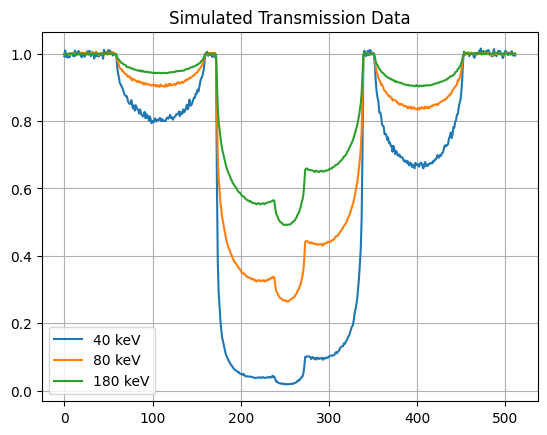

In [16]:
for case_i, gt_spec in enumerate(gt_spec_list):
    plt.plot(trans_list[case_i][3, 25], label=f'{voltage_list[case_i]} keV')
plt.legend()
plt.grid()
plt.title('Simulated Transmission Data')

## B. Spectral Calibration

### B01. FBP Reconstruction using SVMBIR
Reconstructing one CT scan using MBIR.

In [17]:
# Reconstructing one CT scan using MBIR.
sino = -np.log(trans_list[-1]).astype(np.float32)
sino = np.ascontiguousarray(sino, dtype=np.float32) # shape is numAngles, numRows, numCols


startTime = time.time()
recon = svmbir.recon(sino, angles) # shape is numZ, numY, numX
recon = recon/ct_info["psize"][0] # convert ALU^-1 to mm^-1
print('Reconstruction Elapsed Time: ' + str(time.time()-startTime))

Reconstructing axial size (rows,cols)=(512,512).
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/dd251b23001410310f31.2Dsvmatrix
Reconstruction Elapsed Time: 27.353965044021606


In [18]:
recon.shape

(50, 512, 512)

Text(0.5, 1.0, 'Reconstruction')

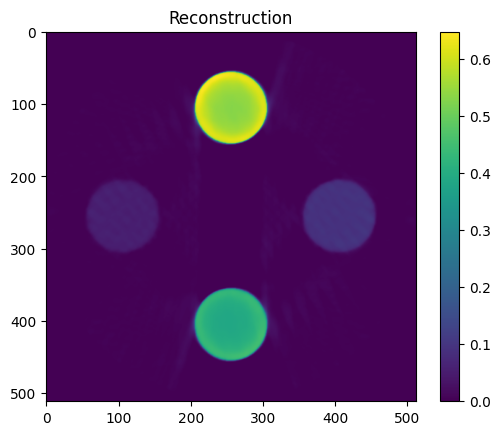

In [19]:
plt.imshow(recon[25])
plt.colorbar()
plt.title('Reconstruction')

### B03. Circle Detection (Optional)
The circle detection provides a coarse bounding box for object segmentation.
One can manually set the bounding box for the object segmentation, if the sample is not cylindrical.

Below is an example to use detect_hough_circles to detect circles on the $25^{th}$ slice of the reconstruction.

In [20]:
from xspec.phantom import detect_hough_circles

In [21]:
help(detect_hough_circles)

Help on function detect_hough_circles in module xspec.phantom:

detect_hough_circles(phantom, radius_range=None, vmin=0, vmax=None, min_dist=100, HoughCircles_params1=300, HoughCircles_params2=1)
    Detects circles in an image using the Hough Circle Transform.
    
    Args:
        phantom (numpy.ndarray): The 2D image to detect circles in.
        radius_range (list of int, optional): The minimum and maximum radius of
            circles to detect. Defaults to a range based on the image size.
        vmin (int, optional): Minimum value for clipping the image before
            detection. Defaults to 0.
        vmax (int, optional): Maximum value for clipping the image before
            detection. If None, the 90th percentile of the image is used.
            Defaults to None.
        min_dist (int, optional): Minimum distance between the centers of the
            detected circles. If too small, multiple neighbor circles may be
            falsely detected in addition to a true one

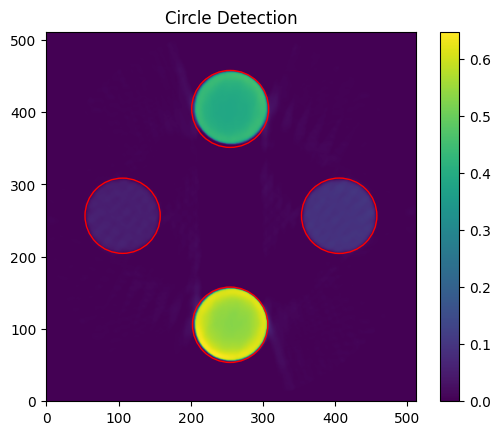

In [22]:
from matplotlib.patches import Circle
import math

plt.imshow(recon[25],origin='lower')
plt.colorbar()
# Get the current axes.
ax = plt.gca()
circles = detect_hough_circles(recon[25], 
                               radius_range=(45, 55), 
                               vmin=0.00, vmax=0.02, 
                               min_dist=200,
                               HoughCircles_params2=10)

# Below is for display and sort the detected circles.
# x is horizontal axis, y is vertical axis. 
circles_values = np.array([np.mean(recon[25][int(y-r):int(y+r),int(x-r):int(x+r)]) for x,y,r in circles])
# Sort `circles` based on the order in `circles_values`
circles = [cir for _, cir in sorted(zip(circles_values, circles))]
# Rearrange based on material ['V', 'Al', 'Ti', 'Mg'] 
circles = [circles[i] for i in [3,1,2,0]]

# Create and add circles to the plot.
for x, y, radius in circles:
    circle = Circle((x, y), radius, color='red', fill=False)
    ax.add_patch(circle)

# Optionally set the aspect of the plot to be equal.
# This makes sure that the circles are not skewed.
ax.set_aspect('equal')
plt.title('Circle Detection')
# Show the plot with the circles.
plt.show()

### B04. Segment Object to get 3D Mask

segment_object is a function to segment one sample from background.

In [23]:
from xspec.phantom import segment_object

In [24]:
help(segment_object)

Help on function segment_object in module xspec.phantom:

segment_object(phantom, vmin, vmax, canny_sigma, roi_radius=None, bbox=None)
    Segments an object within a given region of interest (ROI) or bounding box in an image.
    
    This function creates a segmentation mask for an object in an image. The image values
    are clipped and normalized based on provided minimum and maximum values. Canny edge
    detection is then applied to the normalized image. The edges are filled to create a
    binary mask that segments the object.
    
    Args:
        phantom (np.array): The input image to segment.
        vmin (float): The minimum value for clipping the image.
        vmax (float): The maximum value for clipping the image.
        canny_sigma (float): The standard deviation for the Gaussian filter used in
                             Canny edge detection.
        roi_radius (int, optional): The radius of the circular region of interest. If not
                                    

In [25]:
est_mask_list = []
bbox_half_size = int(np.mean([cir[2] for cir in circles])*1.1)
# Manually set the threshold based on above plot.
vmin_list = [0.02,0.01,0.2,0.01]
vmax_list = [0.7,0.02,0.4,0.02]
# Loop through each slice to get 3D mask.
for vi,cir in enumerate(circles):
    xcenter, ycenter, r = cir
    # Segment object with 3D mask
    # Set different vmin and vmax for different samples.
    # Set bbox to restrict a box region for object segmentation.
    est_mask = [segment_object(
        recon[i], 
        vmin_list[vi], 
        vmax_list[vi], 
        10, # Canny sigma in canny edge detection. Larger value is more possible to connect to a line.
        roi_radius=None,
        bbox=(
            int(ycenter - bbox_half_size),
            int(xcenter - bbox_half_size),
            int(ycenter + bbox_half_size),
            int(xcenter + bbox_half_size)
        )) for i in range(len(recon))]
    est_mask_list.append(np.array(est_mask))


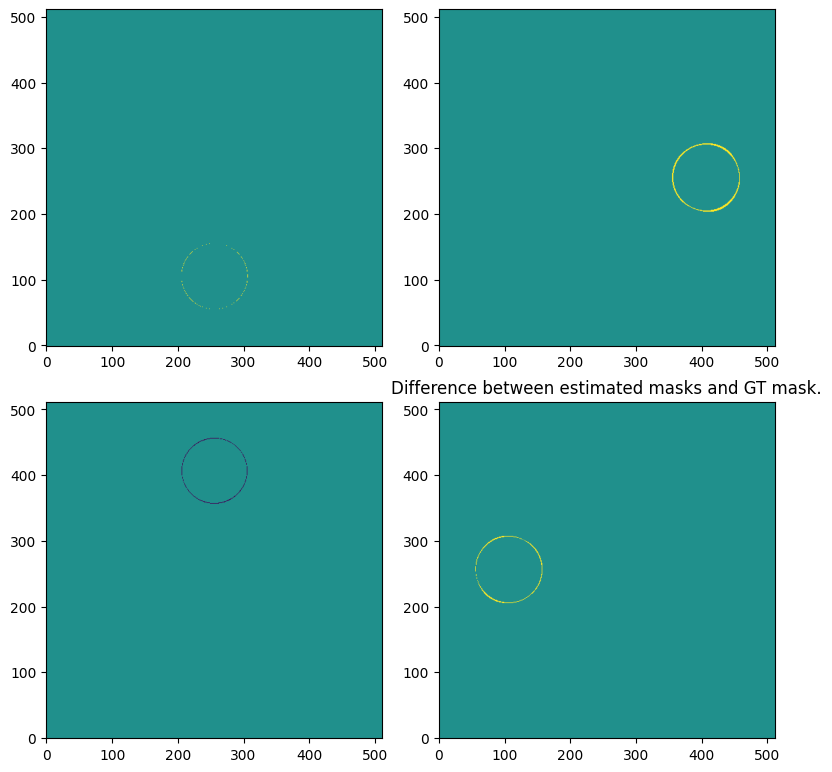

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for j in range(len(est_mask_list)):
    ax = axs.flat[j]
    est_mask = est_mask_list[j]
    gtmask = mask_list[j]
    # Display the image or the difference image.
#     ax.imshow(est_mask[25],origin='lower')
    ax.imshow(est_mask[25].astype('float32')-gtmask[25].astype('float32'),vmin=-1,vmax=1,origin='lower')
# Adjust the layout
plt.tight_layout()
plt.title('Difference between estimated masks and GT mask.')
plt.show()

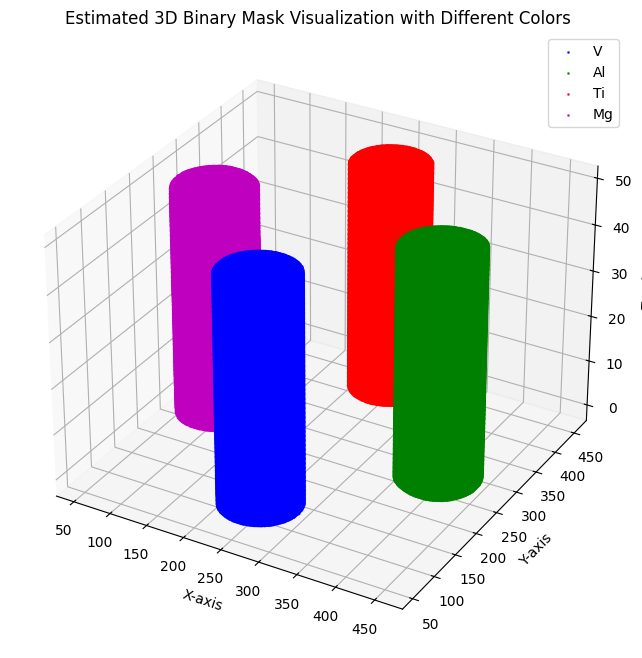

In [27]:
# Define colors for each mask
colors = ['b', 'g', 'r', 'm']  # Blue, Green, Red, Magenta for each est_mask

# Plot the 3D masks using a scatter plot with different colors
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for i, est_mask in enumerate(est_mask_list):
    # Get the coordinates of the points where the mask is 1
    z, y, x = np.where(est_mask == 1)
    ax.scatter(x, y, z, color=colors[i], marker='o', s=1, alpha=0.7, label=sample_mats[i])

# Set labels and title
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Estimated 3D Binary Mask Visualization with Different Colors")
plt.legend()
plt.show()

### B05. Calculate Forward Matrix with Estimated 3D Masks

In [28]:
# Only use 8 different views for spectral calibration
NViews_For_MBSC = 8
projector2 = fw_projector(angles[::ct_info["NViews"]//NViews_For_MBSC], num_channels=ct_info["shape"][1], delta_pixel=ct_info["psize"][0])

In [29]:
est_spec_F = calc_forward_matrix(est_mask_list, lac_vs_E_list, projector2)

Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/93e3ce773cb81f656a7b.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/93e3ce773cb81f656a7b.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/93e3ce773cb81f656a7b.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/93e3ce773cb81f656a7b.2Dsvmatrix


### B06. X-ray System Model Configuration

In [30]:
from xspec.models import Reflection_Source, Filter, Scintillator
from xspec.defs import Material

In [31]:
# Use Spekpy to generate a source spectra dictionary.
takeoff_angles = np.linspace(5,45,11)
src_spec_list = []
for case_i,simkV in enumerate(voltage_list):
    for ta in takeoff_angles:
        # Generate the X-ray spectrum model with Spekpy for each voltage.
        s = sp.Spek(kvp=simkV, th=ta, dk=1,z=1, mas=mas_list[case_i], char=True)
        k, phi_k = s.get_spectrum(edges=False)  # Retrieve energy bins and fluence spectrum [Photons cm^-2 keV^-1]

        # Adjust the fluence for the detector pixel area.
        phi_k = phi_k * ((ct_info['psize'][0] / 10) * (ct_info['psize'][1] / 10))  # Convert pixel size from mm² to cm²

        # Initialize a zero-filled spectrum array with length max_simkV.
        src_spec = np.zeros(max_simkV-1)
        src_spec[:simkV-1] = phi_k  # Assign spectrum values starting from 1.5 keV

        # Add the processed spectrum for this voltage to the list.
        src_spec_list.append(src_spec)

src_spec_list = np.array(src_spec_list)
src_spec_list = src_spec_list.reshape((len(voltage_list),len(takeoff_angles),-1))

In [32]:
# Configure the Reflection Source Model
# Reflection_Source is a PyTorch module that supports gradient descent.
# Reflection_Source initializes with specified source voltage and takeoff angle.
# The set_src_spec_list method assigns a dictionary for each source configuration.
# Reflection_Source.forward() provides interpolated dictionary components for each source.

# Source voltage is set to be fixed by setting minbound and maxbound to None.
# Takeoff angle is estimated in range [5,45] with inital value 25 degree.
sources = [Reflection_Source(voltage=(voltage, None, None), takeoff_angle=(25, 5, 45), single_takeoff_angle=True)
           for voltage in voltage_list]
# Assigning the dictionaries for each source.
for src_i, source in enumerate(sources):
    source.set_src_spec_list(energies, src_spec_list, voltage_list, takeoff_angles)

In [33]:
# Both the filter and scintillator contain discrete and continuous parameters.
# All continuous parameters are defined using a tuple format with an initial value, minimum bound, and maximum bound.
# Any other format is recognized as a discrete parameter.
# Concatenating all component instances (sources, filters, scintillator) into a list, called spectral configuration like [source, filter_1, scintillator_1], 
# allows the Estimator defined in B07 to recognize all parameters, whether discrete or continuous for a scan.
# The spec_models collects all spectral configuration. Each spectral configuration corresponding to a scan.
# The Estimator will then automatically determine all possible combinations for the discrete parameters and optimize the continous parameters.


# Configure Filter Model
# Knowns: Use one filter for both scans.
# Possible filter materials: Al and Cu.
psb_fltr_mat = [Material(formula='Al', density=2.702), 
                Material(formula='Cu', density=8.92)]
filter_1 = Filter(psb_fltr_mat, thickness=(5, 0, 10))

# Configure Scintillator Model
# Knowns: Use one scintillator for both scans.
# Possible scintillator materials
scint_params_list = [
    {'formula': 'CsI', 'density': 4.51},
    {'formula': 'Gd3Al2Ga3O12', 'density': 6.63},
    {'formula': 'Lu3Al5O12', 'density': 6.73},
    {'formula': 'CdWO4', 'density': 7.9},
    {'formula': 'Y3Al5O12', 'density': 4.56},
    {'formula': 'Bi4Ge3O12', 'density': 7.13},
    {'formula': 'Gd2O2S', 'density': 7.32}
]
psb_scint_mat = [Material(formula=scint_p['formula'], density=scint_p['density']) for scint_p in scint_params_list]
scintillator_1 = Scintillator(materials=psb_scint_mat, thickness=(0.25, 0.01, 0.5))

# For each scan using a different source voltage, we define a different total spectral model.
# Each spectral model is a list containing source, filters, and scintillator models. 
# Allow filter_1, ..., filter_n.
spec_models = [[source, filter_1, scintillator_1] for source in sources]

### B07. Spectral Calibration with Simulated Multi-Energy Data

In [34]:
trans_list[0].shape

(64, 50, 512)

In [35]:
# Build Training Set
# Use first 8 views and center 2 slices.
train_rads = [trans[::ct_info["NViews"]//NViews_For_MBSC,10:-10:10] for trans in trans_list]

# Assume a same forward matrix for different scans at different voltages.
forward_matrices = [est_spec_F[:,10:-10:10] for i in range(len(voltage_list))]

print("Training Measurement Shape: \n", train_rads[0].shape,train_rads[1].shape,train_rads[2].shape)
print("Training Forward Matrix Shape: \n",forward_matrices[0].shape,forward_matrices[1].shape,forward_matrices[2].shape)

Training Measurement Shape: 
 (8, 3, 512) (8, 3, 512) (8, 3, 512)
Training Forward Matrix Shape: 
 (8, 3, 512, 179) (8, 3, 512, 179) (8, 3, 512, 179)


In [36]:
from xspec.estimate import Estimate

learning_rate = 0.01 # 0.01 for NNAT_LBFGS and 0.001 for Adam
max_iterations = 5000 # 5000 ~ 10000 would be enough
stop_threshold = 1e-6 
optimizer_type = 'NNAT_LBFGS' # Can also use Adam.

Estimator = Estimate(energies)
# For each scan, add data and calculated forward matrix to Estimator.
for nrad, forward_matrix, concatenate_models in zip(train_rads, forward_matrices, spec_models):
    Estimator.add_data(nrad, forward_matrix, concatenate_models, weight=None)

# Fit data
Estimator.fit(learning_rate=learning_rate,
              max_iterations=max_iterations,
              stop_threshold=stop_threshold,
              optimizer_type=optimizer_type,
              loss_type='transmission',
              logpath=None,
              num_processes=7) # Parallel computing for multiple cpus.

Number of cases for different discrete parameters: 14


2025-03-18 22:08:13,243  - Start Estimation.
2025-03-18 22:08:13,243  - Start Estimation.
2025-03-18 22:08:13,244  - Start Estimation.
2025-03-18 22:08:13,244  - Start Estimation.
2025-03-18 22:08:13,244  - Start Estimation.
2025-03-18 22:08:13,247  - Start Estimation.
2025-03-18 22:08:13,248  - Start Estimation.
2025-03-18 22:08:13,614  - Initial cost: 5.964682e-03
2025-03-18 22:08:13,614  - Initial cost: 4.192700e-03
2025-03-18 22:08:13,614  - Initial cost: 3.235650e-03
2025-03-18 22:08:13,615  - Initial cost: 1.750527e-03
2025-03-18 22:08:13,617  - Initial cost: 2.840402e-03
2025-03-18 22:08:13,628  - Initial cost: 2.653498e-03
2025-03-18 22:08:13,630  - Initial cost: 3.234071e-03
2025-03-18 22:08:16,349  - Iteration: 5
2025-03-18 22:08:16,375  - Iteration: 5
2025-03-18 22:08:16,418  - Iteration: 5
2025-03-18 22:08:16,478  - Iteration: 5
2025-03-18 22:08:16,545  - Iteration: 5
2025-03-18 22:08:16,578  - Iteration: 5
2025-03-18 22:08:16,610  - Iteration: 5
2025-03-18 22:08:17,059  - 

### B08. Result Analysis

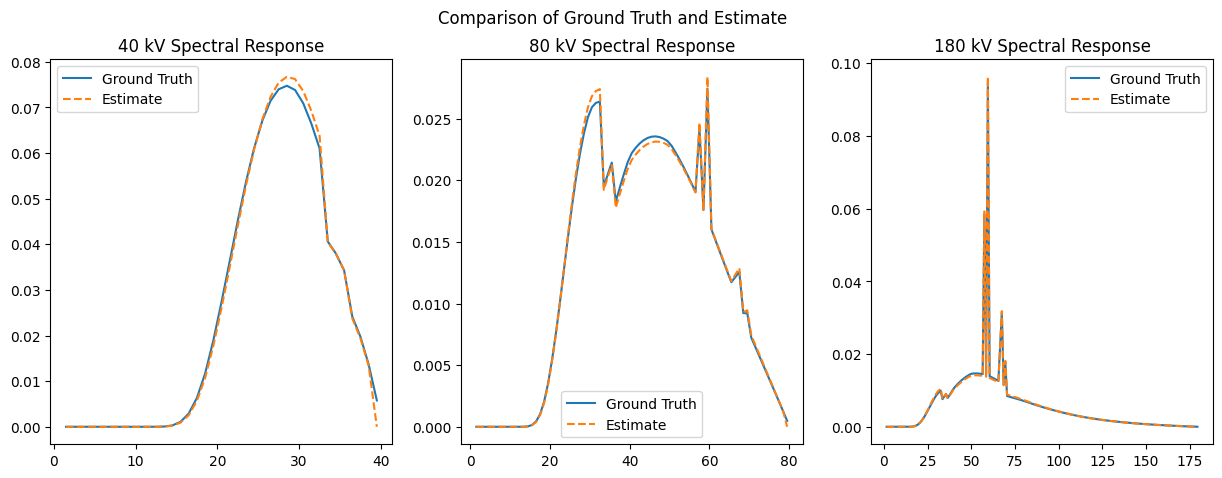

In [37]:
import torch

# Get the estimated effective response for each source voltage.
# Make sure to convert to numpy array from tensor before plotting.
est_sp = Estimator.get_spectra()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax = axs[i]
    with torch.no_grad():
        ax.plot(energies[:voltage_list[i]-1], (gt_spec_list[i]/np.trapz(gt_spec_list[i],energies))[:voltage_list[i]-1],
                label='Ground Truth')
        es = est_sp[i].numpy()
        es /= np.trapz(es,energies)
        ax.plot(energies[:voltage_list[i]-1], es[:voltage_list[i]-1], '--', label='Estimate')

    ax.legend()
    ax.set_title(f'{voltage_list[i]} kV Spectral Response')

fig.suptitle('Comparison of Ground Truth and Estimate')
plt.show()

In [38]:
import pandas as pd

# Return a dictionary containing the estimated parameters.
res_params = Estimator.get_params()

# Ground Truth values
ground_truth = {
    "takeoff_angle (degree)": takeoff_angle,
    "fltr_mat": fltr_mat,
    "fltr_th (mm)": fltr_th,
    "det_mat": det_mat,
    "det_th (mm)": det_th,
}

# Estimated values from res_params
# .item() to return value for an estiamted continous parameter.
# material with .formula is because the class Material contains both formula and density.
estimated = {
    "takeoff_angle (degree)": res_params['Reflection_Source_takeoff_angle'].item(),
    "fltr_mat": res_params['Filter_2_material'].formula,
    "fltr_th (mm)": res_params['Filter_2_thickness'].item(),
    "det_mat": res_params['Scintillator_2_material'].formula,
    "det_th (mm)": res_params['Scintillator_2_thickness'].item(),
}

# Combine into a DataFrame for comparison
df = pd.DataFrame({'Ground Truth': ground_truth, 'Estimated': estimated})

# Display the DataFrame
df


,Ground Truth,Estimated
takeoff_angle (degree),13,16.456303
fltr_mat,Al,Al
fltr_th (mm),3,3.154238
det_mat,CsI,CsI
det_th (mm),0.33,0.371874
